 # NeurIPS 2025 – Open Polymer Prediction

 ### ChemBERTa baseline (multi-task, masked wMAE)

 ### Environment & installs

 On Kaggle you normally pre-install `transformers`, but

 include the `pip` line for local / VS Code runs.

In [1]:
# !pip install -q transformers
# !pip install openpyxl

 ### Imports & configurations

In [2]:
import os, json, random, math, re, gc, warnings, pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import torch.optim as optim
import os

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModel,
    get_cosine_schedule_with_warmup,
)

warnings.filterwarnings("ignore")

SEED          = 42
MODEL_NAME    = "DeepChem/ChemBERTa-77M-MLM"
BATCH_SIZE    = 16          # fits comfortably on Kaggle T4/V100
MAX_LEN       = 128
EPOCHS        = 8
LR            = 2e-5
WARMUP_RATIO  = 0.1
OUTPUT_DIR    = Path("./checkpoints")
OUTPUT_DIR.mkdir(exist_ok=True)
TARGETS = ["Tg", "FFV", "Tc", "Density", "Rg"]


random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # change this device if you use GPU
print("Device:", device)

Device: cuda


 ### 3  Load & clean data

 *Remove only rows with completely missing SMILES; keep all NaNs in targets.*

In [3]:
DATA_DIR = os.path.join(os.getcwd(), 'external_data')

# load the data
train_csv = os.path.join(DATA_DIR, "train.csv")
test_csv  = os.path.join(DATA_DIR, "test.csv")

df_train = pd.read_csv(train_csv)
df_test  = pd.read_csv(test_csv)


print(f"Train shape  : {df_train.shape}")
print(f"Test  shape  : {df_test.shape}")

Train shape  : (7973, 7)
Test  shape  : (3, 2)


### Show test data

In [4]:
df_test.head()

,id,SMILES
0,1109053969,*Oc1ccc(C=NN=Cc2ccc(Oc3ccc(C(c4ccc(*)cc4)(C(F)...
1,1422188626,*Oc1ccc(C(C)(C)c2ccc(Oc3ccc(C(=O)c4cccc(C(=O)c...
2,2032016830,*c1cccc(OCCCCCCCCOc2cccc(N3C(=O)c4ccc(-c5cccc6...


### Load External Data Files from RDKit 

In [5]:
# !pip install -q rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdmolops

def make_smi_canonical(smi):
    try:
        mol = Chem.MolFromSmiles(smi)
        canon_smi = Chem.MolToSmiles(mol, canonical=True)
        return canon_smi
    except:
        return np.nan

In [6]:
# apply SMILES matching from rdkit
df_train['SMILES'] = df_train['SMILES'].apply(lambda x: make_smi_canonical(x))
df_test['SMILES'] = df_test['SMILES'].apply(lambda x: make_smi_canonical(x))

### Add External Data Files From Notebook

In [7]:
# Load Tc_SMILES data
data_tc = pd.read_csv(os.path.join(DATA_DIR,'Tc_SMILES.csv'))
data_tc = data_tc.rename(columns={'TC_mean': 'Tc'})

# Load JCIM data
data_tg2 = pd.read_csv(os.path.join(DATA_DIR,'JCIM_sup_bigsmiles.csv'), usecols=['SMILES', 'Tg (C)'])
data_tg2 = data_tg2.rename(columns={'Tg (C)': 'Tg'})

# Load external excel sheets
data_tg3 = pd.read_excel(os.path.join(DATA_DIR, 'data_tg3.xlsx'))
data_tg3 = data_tg3.rename(columns={'Tg [K]': 'Tg'})
data_tg3['Tg'] = data_tg3['Tg'] - 273.15 # Adjusting Tg values from Kelvin to Celsius

data_tg4 = pd.read_csv(os.path.join(DATA_DIR, 'TgSS_enriched_cleaned.csv'), usecols=['SMILES', 'Tg'])

data_dnst = pd.read_excel(os.path.join(DATA_DIR, 'data_dnst1.xlsx'))
data_dnst = data_dnst.rename(columns={'density(g/cm3)': 'Density'})[['SMILES', 'Density']]

#Apply SMILES transform from RDKit
print("Applying canonical SMILES conversion to extra datasets...")
data_dnst['SMILES'] = data_dnst['SMILES'].apply(lambda s: make_smi_canonical(s))
print("SMILE conversion complete.")

# Adjust to fit internal dataset format
data_dnst = data_dnst[(data_dnst['SMILES'].notnull())&(data_dnst['Density'].notnull())&(data_dnst['Density'] != 'nylon')]
data_dnst['Density'] = data_dnst['Density'].astype('float64')
data_dnst['Density'] -= 0.118 # Adjusting density values to match the competition's dataset

Applying canonical SMILES conversion to extra datasets...
SMILE conversion complete.


[19:32:53] SMILES Parse Error: syntax error while parsing: *O[Si](*)([R])[R]
[19:32:53] SMILES Parse Error: check for mistakes around position 12:
[19:32:53] *O[Si](*)([R])[R]
[19:32:53] ~~~~~~~~~~~^
[19:32:53] SMILES Parse Error: Failed parsing SMILES '*O[Si](*)([R])[R]' for input: '*O[Si](*)([R])[R]'
[19:32:53] SMILES Parse Error: syntax error while parsing: *NC(=O)c4ccc3c(=O)n(c2ccc([R]c1ccc(*)cc1)cc2)c(=O)c3c4
[19:32:53] SMILES Parse Error: check for mistakes around position 28:
[19:32:53] c4ccc3c(=O)n(c2ccc([R]c1ccc(*)cc1)cc2)c(=
[19:32:53] ~~~~~~~~~~~~~~~~~~~~^
[19:32:53] SMILES Parse Error: Failed parsing SMILES '*NC(=O)c4ccc3c(=O)n(c2ccc([R]c1ccc(*)cc1)cc2)c(=O)c3c4' for input: '*NC(=O)c4ccc3c(=O)n(c2ccc([R]c1ccc(*)cc1)cc2)c(=O)c3c4'
[19:32:53] SMILES Parse Error: syntax error while parsing: O=C=N[R1]N=C=O.O[R2]O.O[R3]O
[19:32:53] SMILES Parse Error: check for mistakes around position 7:
[19:32:53] O=C=N[R1]N=C=O.O[R2]O.O[R3]O
[19:32:53] ~~~~~~^
[19:32:53] SMILES Parse Error: F

In [8]:
def add_extra_data(df_train, df_extra, target):
    n_samples_before = len(df_train[df_train[target].notnull()])
    print(f"Applying canonical SMILES conversion for {target}...")
    df_extra['SMILES'] = df_extra['SMILES'].apply(lambda s: make_smi_canonical(s))
    print(f"SMILE conversion complete for {target}.")
    df_extra = df_extra.groupby('SMILES', as_index=False)[target].mean()
    cross_smiles = set(df_extra['SMILES']) & set(df_train['SMILES'])
    unique_smiles_extra = set(df_extra['SMILES']) - set(df_train['SMILES'])

    # Make priority target value from competition's df
    for smile in df_train[df_train[target].notnull()]['SMILES'].tolist():
        if smile in cross_smiles:
            cross_smiles.remove(smile)

    # Imput missing values for competition's SMILES
    for smile in cross_smiles:
        df_train.loc[df_train['SMILES']==smile, target] = df_extra[df_extra['SMILES']==smile][target].values[0]
    
    df_train = pd.concat([df_train, df_extra[df_extra['SMILES'].isin(unique_smiles_extra)]], axis=0).reset_index(drop=True)

    n_samples_after = len(df_train[df_train[target].notnull()])
    print(f'\nFor target "{target}" added {n_samples_after-n_samples_before} new samples!')
    print(f'New unique SMILES: {len(unique_smiles_extra)}')
    return df_train

In [9]:
train = add_extra_data(df_train, data_tc, 'Tc')
train = add_extra_data(train, data_tg2, 'Tg')
train = add_extra_data(train, data_tg3, 'Tg')
train = add_extra_data(train, data_tg4, 'Tg')
train = add_extra_data(train, data_dnst, 'Density')

print('\n'*3, '--- SMILES for training ---', )
for t in TARGETS:
    print(f'"{t}": {len(train[train[t].notnull()])}')

Applying canonical SMILES conversion for Tc...
SMILE conversion complete for Tc.

For target "Tc" added 129 new samples!
New unique SMILES: 129
Applying canonical SMILES conversion for Tg...
SMILE conversion complete for Tg.

For target "Tg" added 151 new samples!
New unique SMILES: 136
Applying canonical SMILES conversion for Tg...
SMILE conversion complete for Tg.

For target "Tg" added 499 new samples!
New unique SMILES: 499
Applying canonical SMILES conversion for Tg...
SMILE conversion complete for Tg.

For target "Tg" added 7083 new samples!
New unique SMILES: 1845
Applying canonical SMILES conversion for Density...
SMILE conversion complete for Density.

For target "Density" added 634 new samples!
New unique SMILES: 473



 --- SMILES for training ---
"Tg": 8244
"FFV": 7030
"Tc": 866
"Density": 1247
"Rg": 614


### Data Preprocessing 

This code is collected from the kaggle notebook (includes a lot of domain-based preprocessing steps)

In [10]:
import networkx as nx
useless_cols = [    
    # Nan data
    'BCUT2D_MWHI',
    'BCUT2D_MWLOW',
    'BCUT2D_CHGHI',
    'BCUT2D_CHGLO',
    'BCUT2D_LOGPHI',
    'BCUT2D_LOGPLOW',
    'BCUT2D_MRHI',
    'BCUT2D_MRLOW',

    # Constant data
    'NumRadicalElectrons',
    'SMR_VSA8',
    'SlogP_VSA9',
    'fr_barbitur',
    'fr_benzodiazepine',
    'fr_dihydropyridine',
    'fr_epoxide',
    'fr_isothiocyan',
    'fr_lactam',
    'fr_nitroso',
    'fr_prisulfonamd',
    'fr_thiocyan',

    # High correlated data >0.95
    'MaxEStateIndex',
    'HeavyAtomMolWt',
    'ExactMolWt',
    'NumValenceElectrons',
    'Chi0',
    'Chi0n',
    'Chi0v',
    'Chi1',
    'Chi1n',
    'Chi1v',
    'Chi2n',
    'Kappa1',
    'LabuteASA',
    'HeavyAtomCount',
    'MolMR',
    'Chi3n',
    'BertzCT',
    'Chi2v',
    'Chi4n',
    'HallKierAlpha',
    'Chi3v',
    'Chi4v',
    'MinAbsPartialCharge',
    'MinPartialCharge',
    'MaxAbsPartialCharge',
    'FpDensityMorgan2',
    'FpDensityMorgan3',
    'Phi',
    'Kappa3',
    'fr_nitrile',
    'SlogP_VSA6',
    'NumAromaticCarbocycles',
    'NumAromaticRings',
    'fr_benzene',
    'VSA_EState6',
    'NOCount',
    'fr_C_O',
    'fr_C_O_noCOO',
    'NumHDonors',
    'fr_amide',
    'fr_Nhpyrrole',
    'fr_phenol',
    'fr_phenol_noOrthoHbond',
    'fr_COO2',
    'fr_halogen',
    'fr_diazo',
    'fr_nitro_arom',
    'fr_phos_ester'
]

def compute_all_descriptors(smiles, desc_names):
    # Add this check to handle non-string types like float/NaN
    if not isinstance(smiles, str):
        return [None] * len(desc_names)

    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return [None] * len(desc_names)
    return [desc[1](mol) for desc in Descriptors.descList if desc[0] not in useless_cols]

def compute_graph_features(smiles, graph_feats):
    # Add this check to handle non-string types like float/NaN
    if not isinstance(smiles, str):
        graph_feats['graph_diameter'].append(0)
        graph_feats['avg_shortest_path'].append(0)
        graph_feats['num_cycles'].append(0)
        return

    mol = Chem.MolFromSmiles(smiles)
    # Add a check in case RDKit fails to parse a valid string
    if mol is None:
        graph_feats['graph_diameter'].append(0)
        graph_feats['avg_shortest_path'].append(0)
        graph_feats['num_cycles'].append(0)
        return
        
    adj = rdmolops.GetAdjacencyMatrix(mol)
    G = nx.from_numpy_array(adj)

    graph_feats['graph_diameter'].append(nx.diameter(G) if nx.is_connected(G) else 0)
    graph_feats['avg_shortest_path'].append(nx.average_shortest_path_length(G) if nx.is_connected(G) else 0)
    graph_feats['num_cycles'].append(len(list(nx.cycle_basis(G))))

def preprocessing(df):
    desc_names = [desc[0] for desc in Descriptors.descList if desc[0] not in useless_cols]
    descriptors = [compute_all_descriptors(smi, desc_names=desc_names) for smi in df['SMILES'].to_list()]

    graph_feats = {'graph_diameter': [], 'avg_shortest_path': [], 'num_cycles': []}
    for smile in df['SMILES']:
         compute_graph_features(smile, graph_feats)
        
    result = pd.concat(
        [
            pd.DataFrame(descriptors, columns=desc_names),
            pd.DataFrame(graph_feats)
        ],
        axis=1
    )

    result = result.replace([-np.inf, np.inf], np.nan)
    return result

In [11]:
train = pd.concat([train, preprocessing(train)], axis=1)
test = pd.concat([df_test, preprocessing(df_test)], axis=1)

# Find constant columns for each target
all_features = train.columns[7:].tolist()
features = {}
for target in TARGETS:
    const_descs = []
    for col in train.columns.drop(TARGETS):
        if train[train[target].notnull()][col].nunique() == 1:
            const_descs.append(col)
    features[target] = [f for f in all_features if f not in const_descs]

In [12]:
print("size of train:", train.shape)
print("size of not null Tg in train:", train['Tg'].notnull().sum())
print("size of not null FFV in train:", train['FFV'].notnull().sum())
print("size of not null Tc in train:", train['Tc'].notnull().sum())
print("size of not null Density in train:", train['Density'].notnull().sum())
print("size of not null Rg in train:", train['Rg'].notnull().sum())

size of train: (11055, 159)
size of not null Tg in train: 8244
size of not null FFV in train: 7030
size of not null Tc in train: 866
size of not null Density in train: 1247
size of not null Rg in train: 614


In [13]:
print("features: ", features)

features:  {'Tg': ['MaxAbsEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'MaxPartialCharge', 'FpDensityMorgan1', 'AvgIpc', 'BalabanJ', 'Ipc', 'Kappa2', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA7', 'SlogP_VSA8', 'TPSA', 'EState_VSA1', 'EState_VSA10', 'EState_VSA11', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'EState_VSA6', 'EState_VSA7', 'EState_VSA8', 'EState_VSA9', 'VSA_EState1', 'VSA_EState10', 'VSA_EState2', 'VSA_EState3', 'VSA_EState4', 'VSA_EState5', 'VSA_EState7', 'VSA_EState8', 'VSA_EState9', 'FractionCSP3', 'NHOHCount', 'NumAliphaticCarbocycles', 'NumAliphatic

### Data Modelling Methods

 #### Tokeniser Embeddings (ChemBERTa) + Features (LightGBM)

In [14]:
import torch
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from tqdm.auto import tqdm

# --- Load Model and Tokenizer ---
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
bert_model = AutoModel.from_pretrained(MODEL_NAME).to(device)
bert_model.eval() # Set model to evaluation mode

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(600, 384, padding_idx=1)
    (position_embeddings): Embedding(515, 384, padding_idx=1)
    (token_type_embeddings): Embedding(1, 384)
    (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.144, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-2): 3 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.109, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
            (dr

In [15]:
@torch.no_grad()
def get_bert_embeddings(smiles_list, model, tokenizer):
    """
    Generates ChemBERTa embeddings for a list of SMILES strings.
    """
    all_embeddings = []
    # Process in batches to handle large datasets
    for i in tqdm(range(0, len(smiles_list), BATCH_SIZE), desc="Generating Embeddings"):
        batch_smiles = smiles_list[i:i+BATCH_SIZE]
        inputs = tokenizer(
            batch_smiles,
            padding=True,
            truncation=True,
            max_length=MAX_LEN,
            return_tensors="pt",
        ).to(device)
        
        # Get last hidden state and extract the [CLS] token embedding (index 0)
        outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        all_embeddings.append(batch_embeddings)
        
    return np.vstack(all_embeddings)

In [16]:
# --- Generate and Store Embeddings ---

# Assuming 'train' and 'test' DataFrames are already loaded and preprocessed
train_smiles = train["SMILES"].fillna("").tolist()
test_smiles = test["SMILES"].fillna("").tolist()

train_embeddings = get_bert_embeddings(train_smiles, bert_model, tokenizer)
test_embeddings = get_bert_embeddings(test_smiles, bert_model, tokenizer)

# Create new DataFrames from the embeddings
embedding_cols = [f"bert_{i}" for i in range(train_embeddings.shape[1])]
train_embeddings_df = pd.DataFrame(train_embeddings, columns=embedding_cols, index=train.index)
test_embeddings_df = pd.DataFrame(test_embeddings, columns=embedding_cols, index=test.index)

print("ChemBERTa embeddings generated successfully.")

# Show embeddings example
train_embeddings_df.head()

Generating Embeddings:   0%|          | 0/691 [00:00<?, ?it/s]

Generating Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

ChemBERTa embeddings generated successfully.


,bert_0,bert_1,bert_2,bert_3,bert_4,bert_5,bert_6,bert_7,bert_8,bert_9,...,bert_374,bert_375,bert_376,bert_377,bert_378,bert_379,bert_380,bert_381,bert_382,bert_383
0,0.022447,-0.579114,0.289603,-0.060944,0.183871,0.517721,0.056384,0.034416,-0.209738,0.069444,...,-0.020919,0.060327,-0.247529,-0.102126,0.265501,-0.357373,-0.073352,-0.076586,0.199717,-0.547076
1,-0.201801,-0.302374,0.147833,0.034031,0.205542,-0.333111,0.011501,-0.183513,0.129865,0.361760,...,-0.294717,0.161647,-0.021701,0.107325,-0.378316,-0.141005,-0.010823,-0.207105,0.024389,-0.175160
2,-0.465605,-0.188595,0.081273,-0.048565,0.351969,-0.085701,-0.206335,-0.082275,-0.221433,0.272269,...,-0.187803,0.018089,0.048711,-0.037528,-0.126294,-0.627802,0.174310,-0.295922,0.271889,-0.097588
3,-0.123705,-0.225717,-0.045737,0.051345,0.045988,-0.393736,-0.021946,-0.064245,0.141683,0.384705,...,-0.155664,0.178358,-0.187769,-0.076331,-0.220224,-0.164670,0.008902,-0.302105,0.059858,-0.069625
4,-0.301286,-0.230198,-0.192647,0.004276,0.104673,-0.211823,-0.237180,-0.147953,-0.133224,0.328705,...,-0.103685,0.066055,-0.114252,-0.027972,-0.134052,-0.370374,0.122027,-0.304038,0.149455,-0.108380


In [17]:
# ======================================================================================
# FEATURE ENGINEERING FOR TG
# ======================================================================================


print(features['Tg'][:10]) #These are some of the original features for Tg, there is 150 of these

print(embedding_cols[-10:]) #These are some of the embedding features, there is 384 of these



['MaxAbsEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'MaxPartialCharge', 'FpDensityMorgan1', 'AvgIpc', 'BalabanJ']
['bert_374', 'bert_375', 'bert_376', 'bert_377', 'bert_378', 'bert_379', 'bert_380', 'bert_381', 'bert_382', 'bert_383']


In [18]:
# --- Merge Embeddings with Original Features ---
# Concatenate the original dataframes with the new embedding dataframes
train_combined = pd.concat([train, train_embeddings_df], axis=1)
test_combined = pd.concat([test, test_embeddings_df], axis=1)

# A quick check before we modify the dictionary
print(f"Number of original features for 'Tg': {len(features['Tg'])}")

# Loop through each target in your dictionary and add the embedding features
for target_name in features:
    # Get the original list of engineered features for the current target
    original_engineered_features = features[target_name]
    
    # Create the new, combined list
    features[target_name] = original_engineered_features + embedding_cols

print("--- Update Complete ---")
print(f"New number of features for 'Tg': {len(features['Tg'])}")
print(f"New number of features for 'FFV': {len(features['FFV'])}")
print(f"New number of features for 'Tc': {len(features['Tc'])}")
print(f"New number of features for 'Density': {len(features['Density'])}")
print(f"New number of features for 'Rg': {len(features['Rg'])}")

Number of original features for 'Tg': 152
--- Update Complete ---
New number of features for 'Tg': 536
New number of features for 'FFV': 535
New number of features for 'Tc': 522
New number of features for 'Density': 528
New number of features for 'Rg': 520


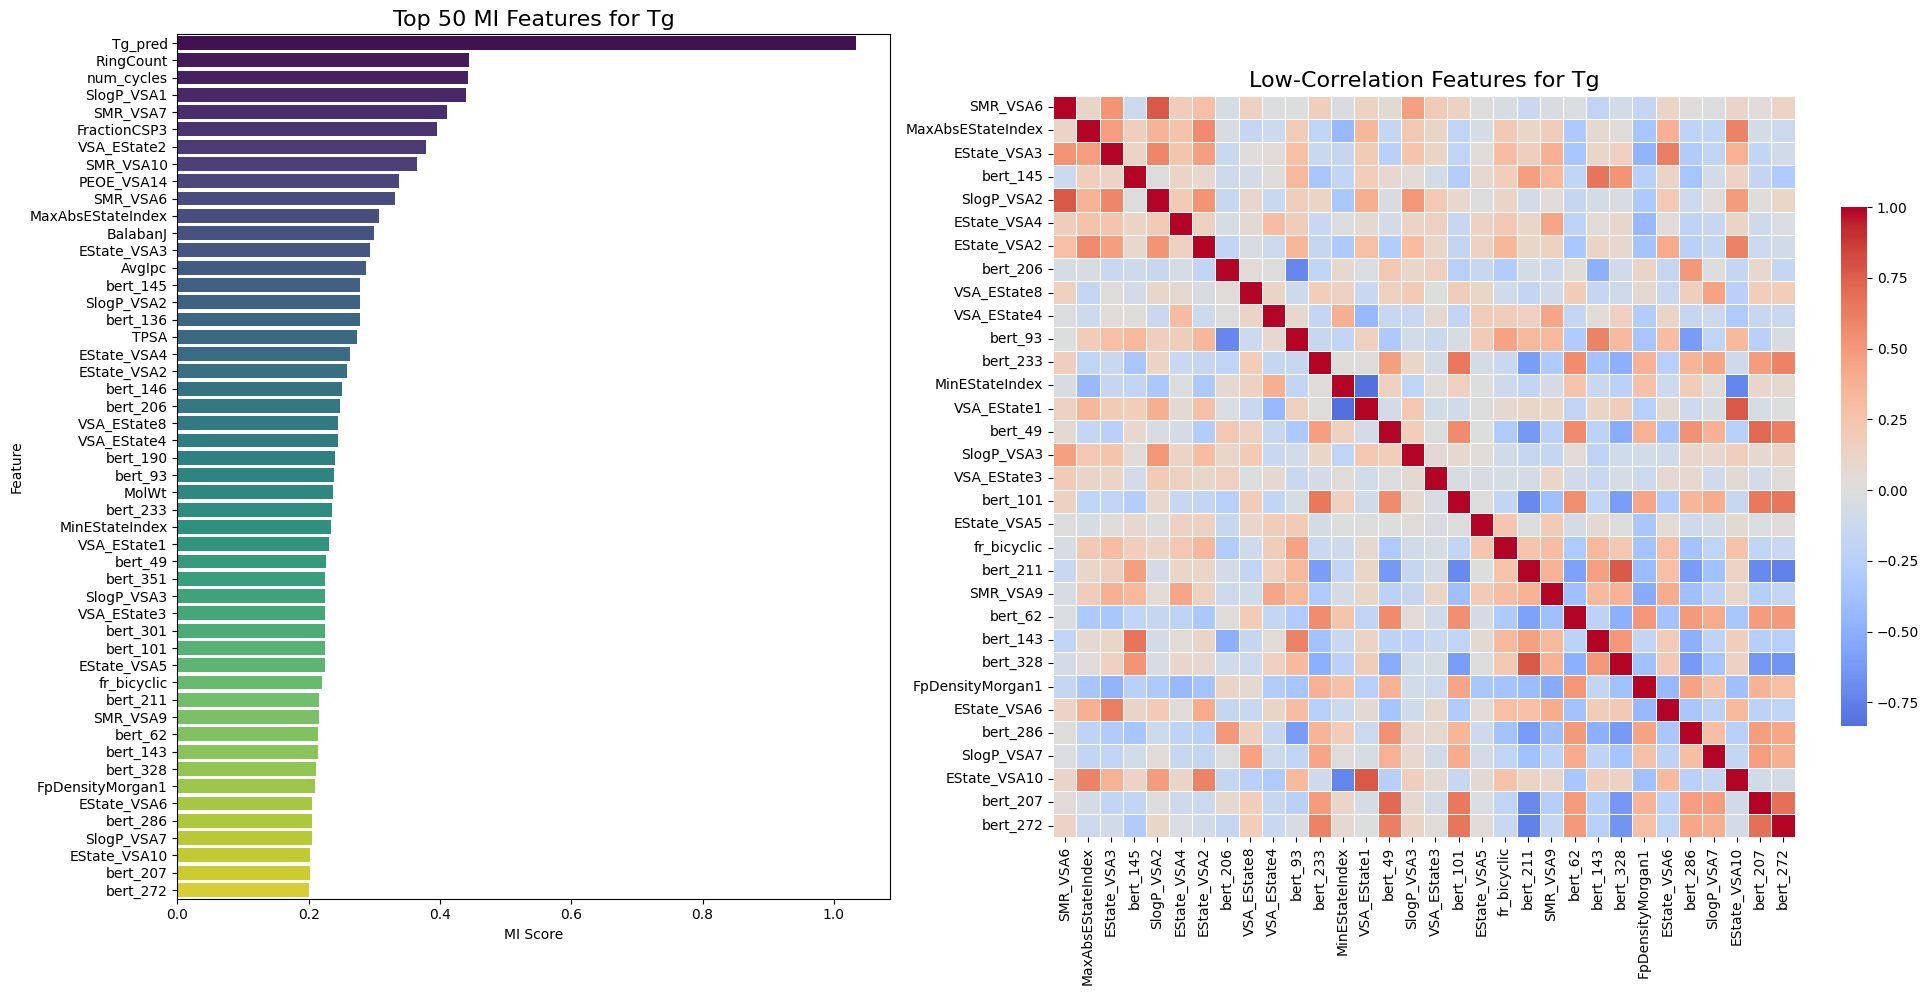

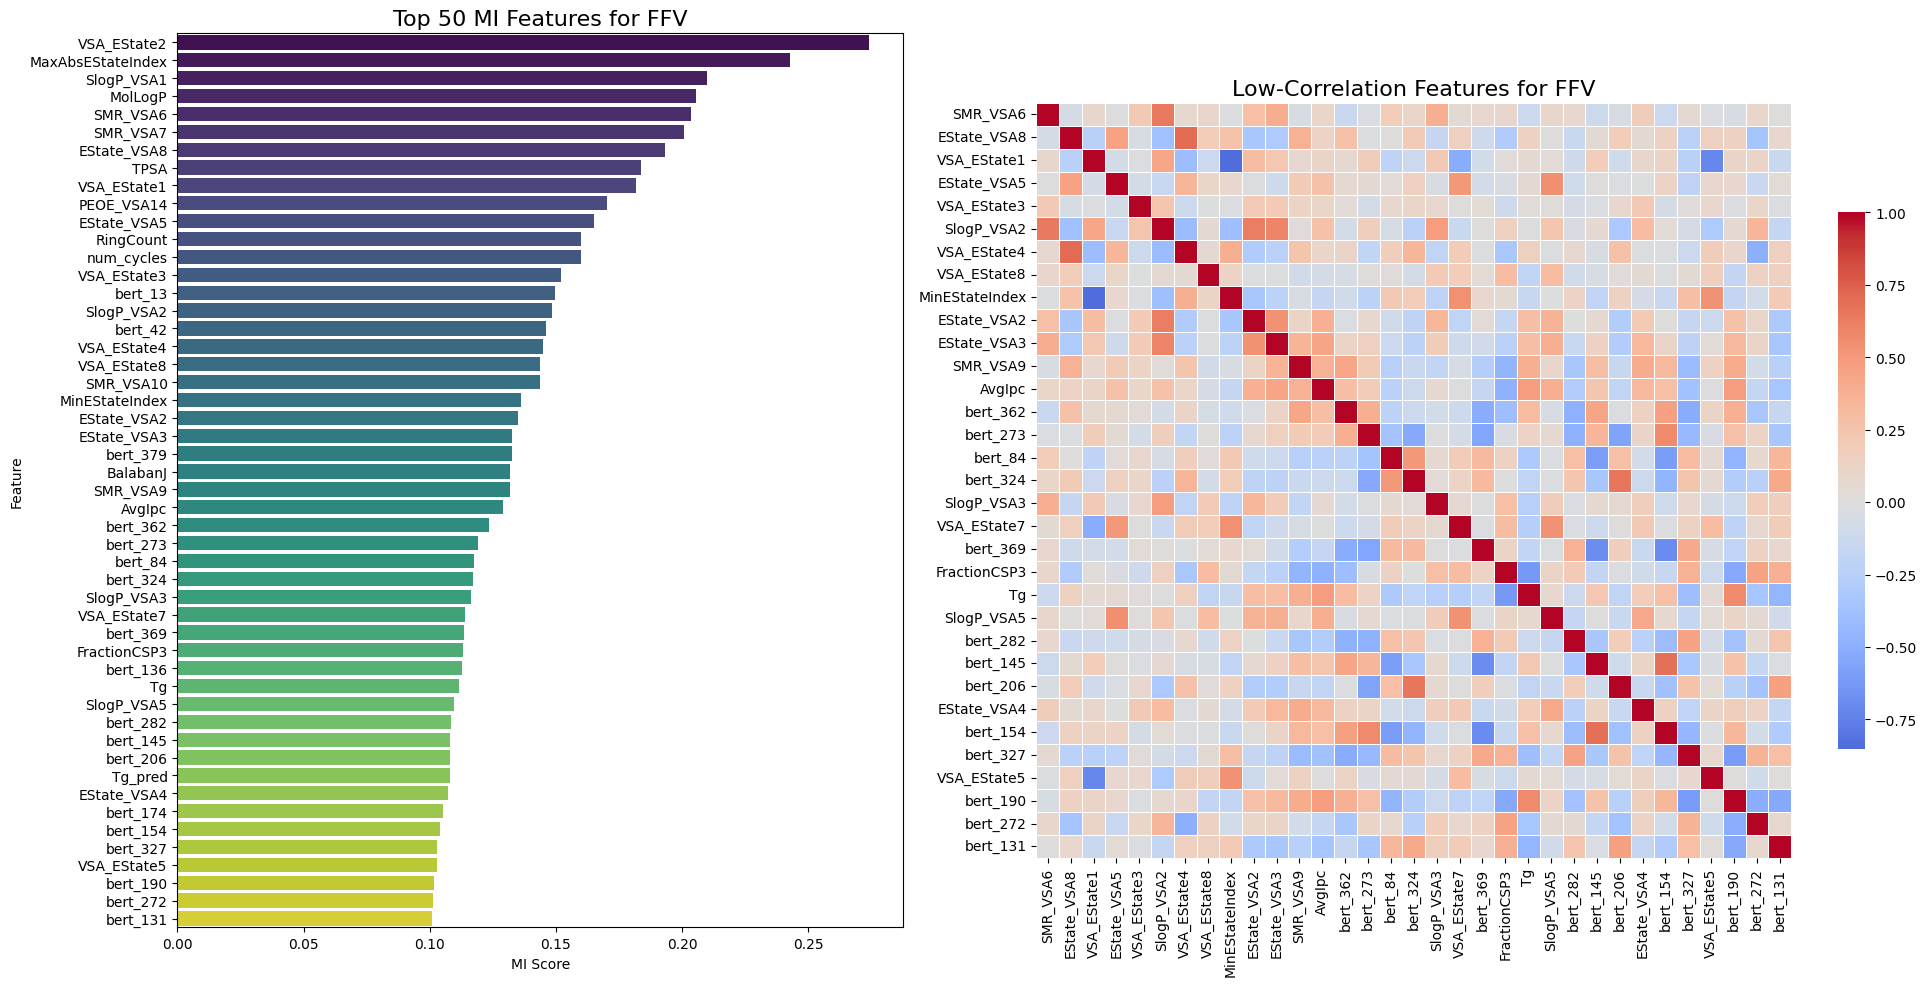

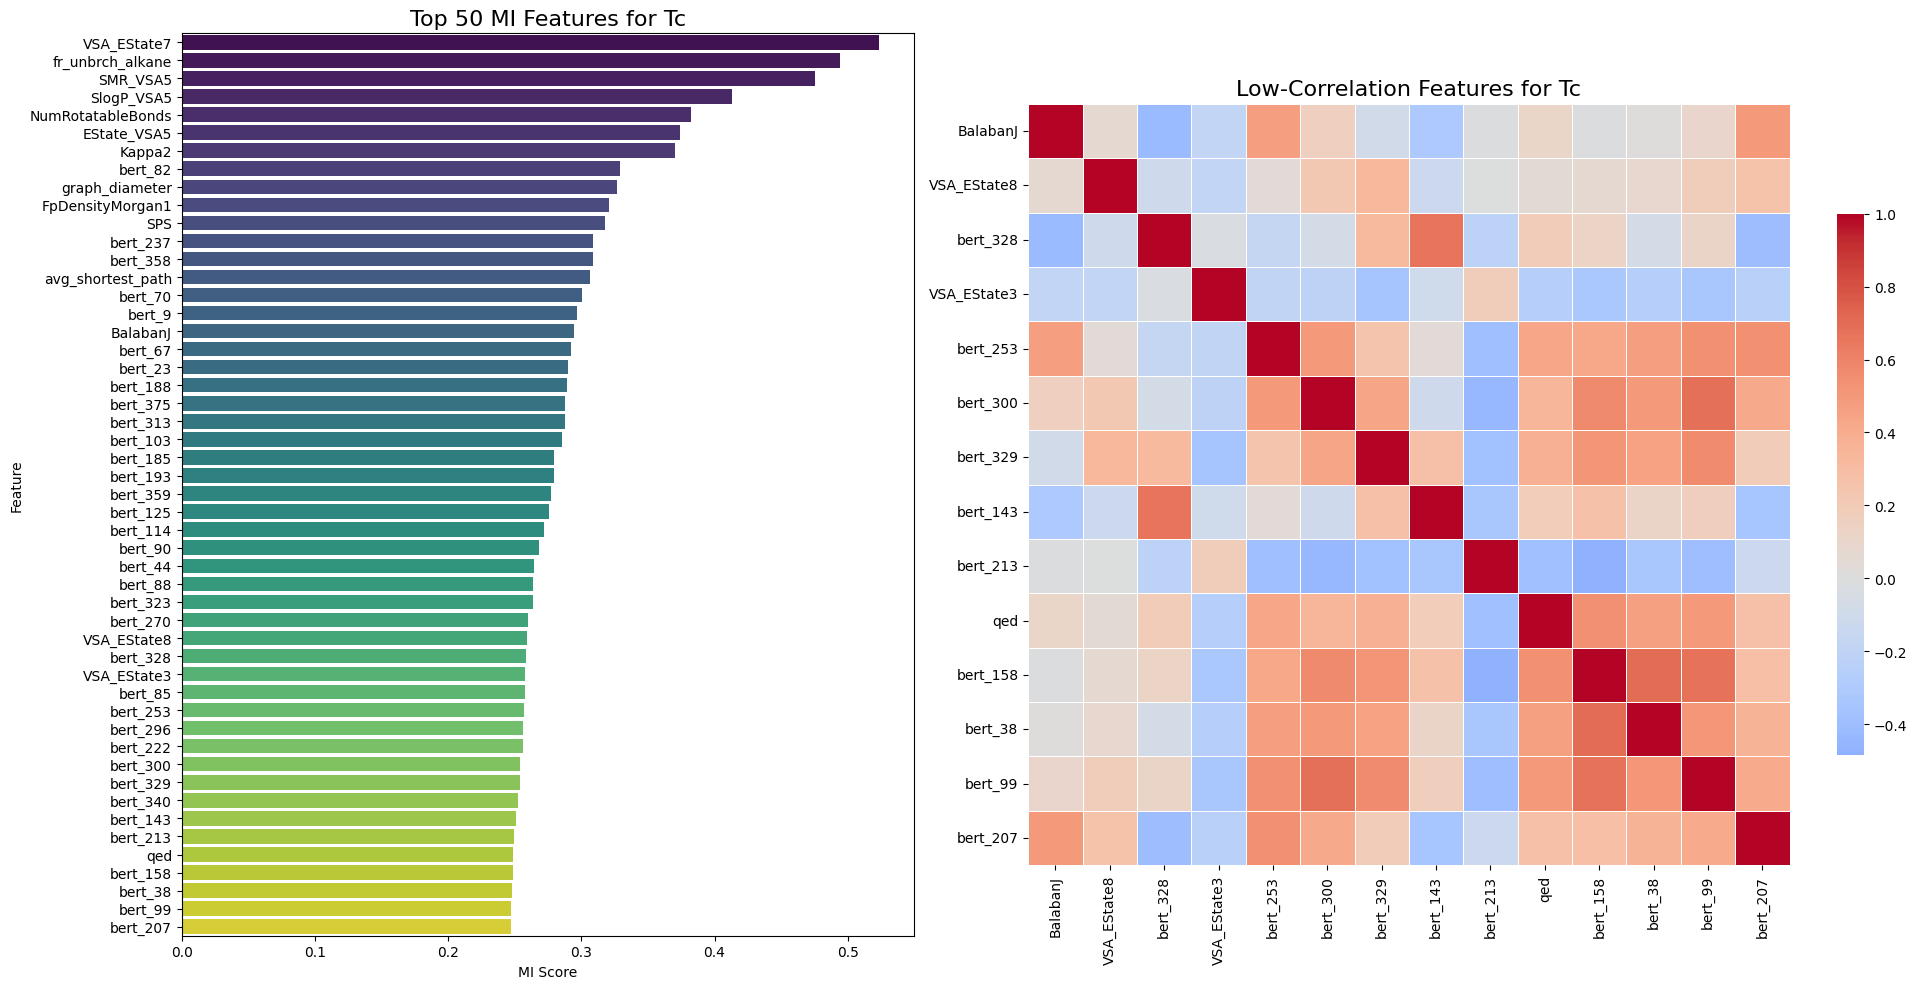

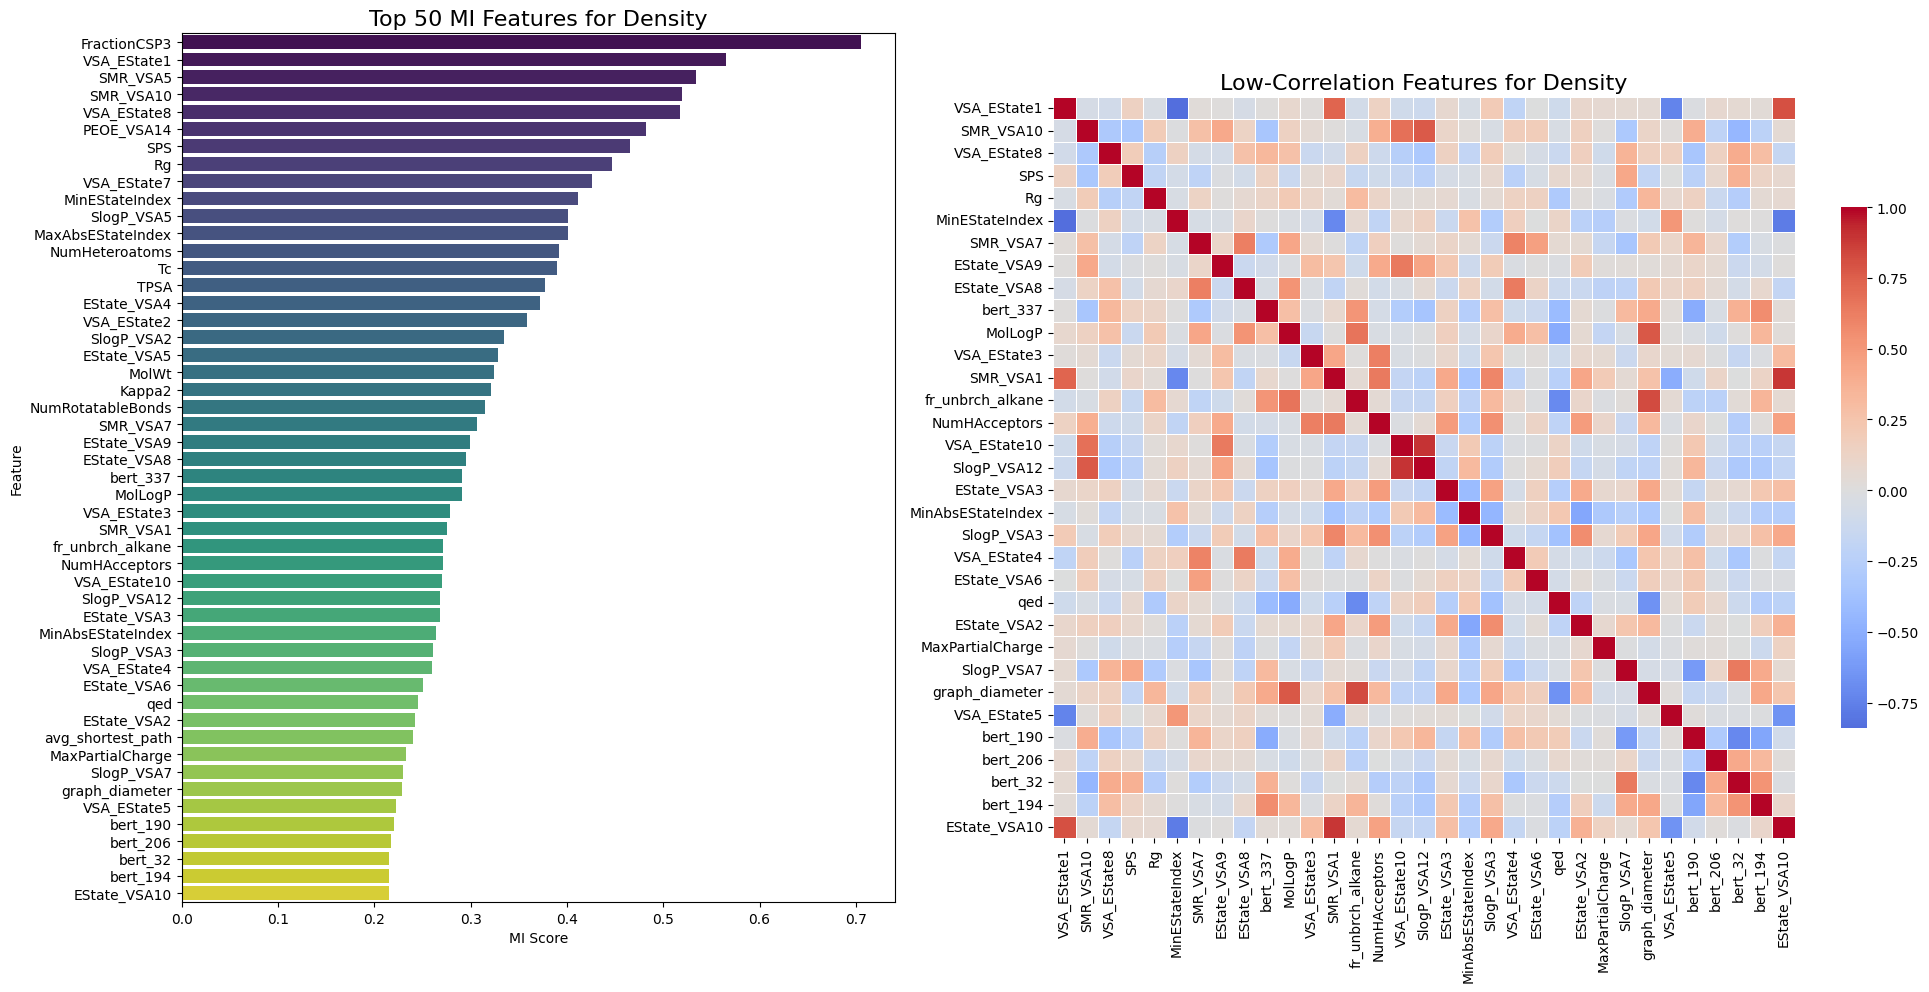

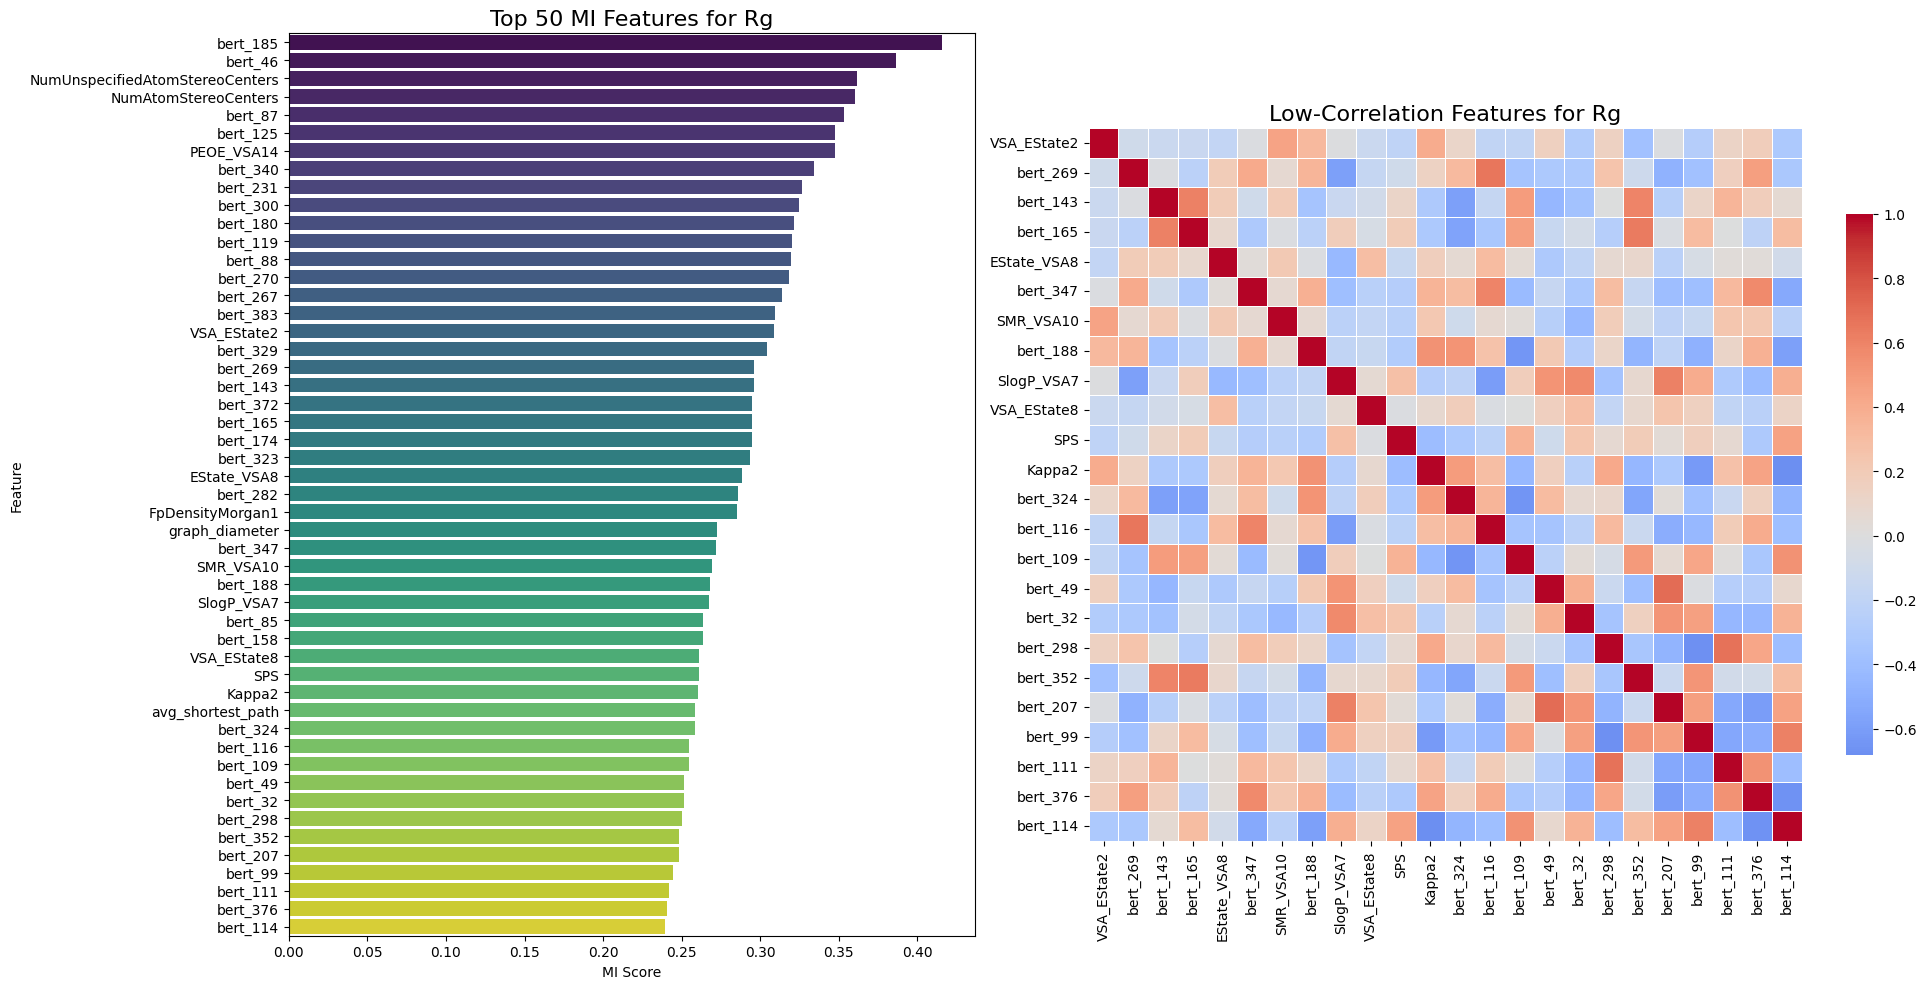

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression

# Example targets
targets = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']
USEFUL_FEATURES_DICT = {}
THRESHOLDS_FOR_TARGETS = {
    'Tg': 12.0,
    'FFV': 10.0,
    'Tc': 7.0,
    'Density': 10.0,
    'Rg': 10.0
}
for TARGET in targets:
    # 📦 Prep features and target
    feature_cols = [col for col in train_combined.columns if col not in [TARGET, 'SMILES', 'id']]
    X = train_combined[feature_cols]
    y = train_combined[TARGET]

    X.drop(columns=['SMILES', TARGET], errors='ignore', inplace=True)

    if y.isnull().any():
        valid_idx = y.notnull()
        X = X.loc[valid_idx]
        y = y.loc[valid_idx]

    X = X.fillna(X.mean())  # MI hates NaNs

    # 🎯 Mutual Info Computation
    mi_scores = mutual_info_regression(X, y, random_state=42)
    mi_series = pd.Series(mi_scores, index=feature_cols).sort_values(ascending=False)
    top_50_features = mi_series.head(50)
    X_top50 = X[top_50_features.index]

    # 🔥 Correlation map (dropping highly redundant features)
    corr_matrix = X_top50.corr()
    threshold_score = THRESHOLDS_FOR_TARGETS[TARGET]
    
    for col in corr_matrix.columns:
        sum_score = corr_matrix[col].abs().sum()
        if sum_score > threshold_score:
            corr_matrix.drop(columns=col, inplace=True)
            corr_matrix.drop(index=col, inplace=True)

    USEFUL_FEATURES_DICT[TARGET] = corr_matrix.columns.tolist()

    # ===========================
    # 🎨 SIDE-BY-SIDE VISUALIZATION
    # ===========================
    fig, axes = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={'width_ratios': [1, 1.3]})
    
    # 📊 Mutual Info Barplot
    sns.barplot(
        y=top_50_features.index,
        x=top_50_features.values,
        palette="viridis",
        ax=axes[0]
    )
    axes[0].set_title(f"Top 50 MI Features for {TARGET}", fontsize=16)
    axes[0].set_xlabel("MI Score")
    axes[0].set_ylabel("Feature")

    # 🧊 Correlation Heatmap
    sns.heatmap(
        corr_matrix,
        cmap="coolwarm",
        annot=False,
        fmt=".2f",
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.6},
        center=0,
        ax=axes[1]
    )
    axes[1].set_title(f"Low-Correlation Features for {TARGET}", fontsize=16)
    axes[1].tick_params(axis='x', rotation=90)
    axes[1].tick_params(axis='y', rotation=0)

    plt.tight_layout()
    plt.show()


In [20]:
print(USEFUL_FEATURES_DICT)

{'Tg': ['SMR_VSA6', 'bert_145', 'SlogP_VSA2', 'EState_VSA4', 'EState_VSA2', 'bert_206', 'VSA_EState8', 'VSA_EState4', 'bert_93', 'MinEStateIndex', 'VSA_EState1', 'EState_VSA5', 'SlogP_VSA3', 'fr_bicyclic', 'bert_101', 'VSA_EState3', 'bert_62', 'bert_143', 'bert_328', 'FpDensityMorgan1', 'SlogP_VSA7', 'SMR_VSA9', 'bert_286', 'bert_207', 'EState_VSA10', 'bert_272', 'SMR_VSA5', 'bert_30'], 'FFV': ['SMR_VSA6', 'EState_VSA8', 'VSA_EState1', 'EState_VSA5', 'VSA_EState3', 'SlogP_VSA2', 'VSA_EState4', 'VSA_EState8', 'MinEStateIndex', 'EState_VSA2', 'EState_VSA3', 'AvgIpc', 'bert_362', 'bert_273', 'bert_84', 'bert_324', 'SlogP_VSA3', 'bert_369', 'VSA_EState7', 'FractionCSP3', 'Tg', 'SlogP_VSA5', 'bert_282', 'bert_145', 'bert_206', 'EState_VSA4', 'bert_154', 'bert_327', 'bert_190', 'VSA_EState5', 'bert_272', 'bert_131', 'bert_211'], 'Tc': ['BalabanJ', 'VSA_EState8', 'bert_328', 'bert_253', 'bert_222', 'bert_143', 'bert_329', 'bert_213', 'qed', 'bert_38', 'VSA_EState3', 'bert_158', 'bert_99', 'be

### MAE Metric Definition

In [21]:
def mae(y_true, y_pred):
    """
    Mean Absolute Error (MAE) loss function.
    Args:
        y_true (torch.Tensor): True target values.
        y_pred (torch.Tensor): Predicted target values.
    Returns:
        torch.Tensor: Computed MAE loss.
    """
    return sum(abs(true - pred) for true, pred in zip(y_true, y_pred)) / len(y_true)

### K-Fold Training Loop for Model (LightGBM External Features + BERT Embeddings)

In [ ]:
!pip install -q lightgbm
import lightgbm as lgb
import pickle
from sklearn.model_selection import KFold

# --- Configuration from your original notebook ---
FOLDS = 5

base_params = {
    'device_type': 'gpu', # change to GPU if available
    'n_estimators': 10_000,
    'objective': 'regression_l1',
    'metric': 'mae',
    'verbosity': -1,
    'num_leaves': 69,
    'min_data_in_leaf': 2,
    'learning_rate': 0.026637639805993162,
    'max_bin': 255,
    'feature_fraction': 0.7859035809967311, 
    'bagging_fraction': 0.9159812258732549, 
    'bagging_freq': 3,
    'lambda_l1':3.8741335005648767, 
    'lambda_l2': 4.243674331615196
}
TARGETS = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']
# --- Main Training Loop (using your code structure) ---
for target in TARGETS:
    print(f'TARGET {target}')
    # Use the new dataframe with combined features
    train_part = train_combined[train_combined[target].notnull()].reset_index(drop=True)
    
    # Initialize prediction columns
    test_combined[target] = 0
    oof_lgb = np.zeros(len(train_part))
    scores = []
    
    kf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
    for i, (trn_idx, val_idx) in enumerate(kf.split(train_part, train_part[target])):
        print(f"--- Fold {i+1} ---")
        
        # Use the comprehensive feature list for training and validation sets
        x_trn = train_part.loc[trn_idx, USEFUL_FEATURES_DICT[target]]
        y_trn = train_part.loc[trn_idx, target]
        x_val = train_part.loc[val_idx, USEFUL_FEATURES_DICT[target]]
        y_val = train_part.loc[val_idx, target]

        model_lgb = lgb.LGBMRegressor(**base_params)
        model_lgb.fit(
            x_trn, y_trn,
            eval_set=[(x_val, y_val)],

            callbacks=[
                lgb.early_stopping(
                    stopping_rounds=300,
                    verbose=5000,
                ),
                lgb.log_evaluation(2500)
            ],
        )
        
        # Save the trained model
        with open(os.path.join(OUTPUT_DIR, f'lgb_{target}_fold_{i}.pkl', 'wb')) as f:
            pickle.dump(model_lgb, f)

        val_preds = model_lgb.predict(x_val, num_iteration=model_lgb.best_iteration_)
        score = mae(y_val, val_preds)
        scores.append(score)
        print(f'MAE: {np.round(score, 5)}')
        
        oof_lgb[val_idx] = val_preds
        
        # Predict on the test set (which also includes embeddings)
        test_combined[target] += model_lgb.predict(
            test_combined[USEFUL_FEATURES_DICT[target]], 
            num_iteration=model_lgb.best_iteration_
        ) / FOLDS

    # You might want to save the OOF predictions for later analysis
    train_combined.loc[train_combined[target].notnull(), f'{target}_pred'] = oof_lgb

    print(f'Mean MAE: {np.round(np.mean(scores), 5)}')
    print(f'Std MAE: {np.round(np.std(scores), 5)}')
    print('-'*30)

TARGET Tg
--- Fold 1 ---
Training until validation scores don't improve for 300 rounds
[2500]	valid_0's l1: 31.9969
[5000]	valid_0's l1: 31.7234
[7500]	valid_0's l1: 31.5579
Early stopping, best iteration is:
[7792]	valid_0's l1: 31.5354
MAE: 31.53544
--- Fold 2 ---
Training until validation scores don't improve for 300 rounds


KeyboardInterrupt: 

### Plot Results from Model

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

print("--- Visualizing Out-of-Fold Predictions vs. Actuals ---")

for t in TARGETS:
    # Use your main dataframe containing the predictions
    plot_df = train_combined[train_combined[t].notnull()]
    
    preds = plot_df[f'{t}_pred']
    vals = plot_df[t]
    
    # Determine the plot limits to make a square plot
    line_min = min(preds.min(), vals.min())
    line_max = max(preds.max(), vals.max())
    
    # Create the scatter plot
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=preds, y=vals, alpha=0.5)
    
    # Add the y=x line for reference (a perfect model)
    plt.plot([line_min, line_max], [line_min, line_max], color='red', linewidth=2, linestyle='dashed')
    
    plt.title(f'Predictions vs. Actuals for {t}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.show()

### Evaluation (Using Metrics From the Competition)

In [ ]:
import pandas as pd
import numpy as np

# Minimum and Mamimum value of each Target Property (Hardcoded)
MINMAX_DICT =  {
    'Tg': [-148.0297376, 472.25],
    'FFV': [0.2269924, 0.77709707],
    'Tc': [0.0465, 0.524],
    'Density': [0.748691234, 1.840998909],
    'Rg': [9.7283551, 34.672905605],
}

In [ ]:
def scaling_error(labels, preds, property):
    # Function to rescale labels
    error = np.abs(labels - preds)
    min_val, max_val = MINMAX_DICT[property]
    label_range = max_val - min_val
    return np.mean(error / label_range)

def get_property_weights(labels):
    property_weight = []
    for property in MINMAX_DICT.keys():
        # Changed this line to use .notna().sum()
        valid_num = labels[property].notna().sum()
        property_weight.append(valid_num)
        
    property_weight = np.array(property_weight)
    property_weight = np.sqrt(1 / property_weight)
    return (property_weight / np.sum(property_weight)) * len(property_weight)

# MODIFIED to correctly handle NaN values instead of -9999
def wmae_score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    # Weighted MAE: Metric Used by the Competition
    chemical_properties = list(MINMAX_DICT.keys())
    property_maes = []
    property_weights = get_property_weights(solution[chemical_properties])
    
    for property in chemical_properties:
        # Changed this line to use .notna()
        is_labeled = solution[property].notna()
        property_maes.append(scaling_error(solution.loc[is_labeled, property], submission.loc[is_labeled, property], property))

    if len(property_maes) == 0:
        raise RuntimeError('No labels')
        
    return float(np.average(property_maes, weights=property_weights))

In [ ]:
# Prepare the solution dataframe (true values) from your main dataframe
tr_solution = train_combined[['id'] + TARGETS]

# Prepare the submission dataframe (OOF predictions)
pred_cols = [t + '_pred' for t in TARGETS]
tr_submission = train_combined[['id'] + pred_cols]

# Rename prediction columns to match solution columns (e.g., 'Tg_pred' -> 'Tg')
tr_submission.columns = ['id'] + TARGETS

# Calculate and print the final wMAE score
final_score = wmae_score(tr_solution, tr_submission, row_id_column_name='id')
print(f"Final Out-of-Fold wMAE Score: {round(final_score, 5)}")

### Feature Importance & Correlation Anlysis

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

FOLDS = 5
N_TOP_FEATURES = 50  # Define how many of the best independent features you want to keep
CORRELATION_THRESHOLD = 0.75 # Define the threshold for removing redundant features

# STEP 1: LOAD MODELS AND CALCULATE AVERAGE FEATURE IMPORTANCES
all_feature_importances = {}
master_feature_list = set()

print("--- Step 1: Loading Models and Calculating Feature Importances ---")
for target in TARGETS:
    feature_importance_df = pd.DataFrame()
    for i in range(FOLDS):
        with open(f'lgb_{target}_fold_{i}.pkl', 'rb') as f:
            model_lgb = pickle.load(f)
        
        fold_df = pd.DataFrame()
        fold_df["feature"] = model_lgb.feature_name_
        fold_df["importance"] = model_lgb.feature_importances_
        feature_importance_df = pd.concat([feature_importance_df, fold_df], ignore_index=True)
    
    mean_importance_df = feature_importance_df.groupby("feature")["importance"].mean().sort_values(ascending=False).reset_index()
    all_feature_importances[target] = mean_importance_df
    master_feature_list.update(mean_importance_df['feature'])

print(f"Importance scores calculated for {len(master_feature_list)} unique features.")

# STEP 2: IDENTIFY AND REMOVE REDUNDANT FEATURES (FROM THE ENTIRE SET)
print("\n--- Step 2: Identifying Redundant Features ---")
corr_matrix = train_combined[list(master_feature_list)].corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

highly_correlated_features = [column for column in upper_tri.columns if any(upper_tri[column] > CORRELATION_THRESHOLD)]
features_to_drop = set()

for feature in highly_correlated_features:
    correlated_with_feature = upper_tri[feature][upper_tri[feature] > CORRELATION_THRESHOLD].index.tolist()
    group = correlated_with_feature + [feature]
    
    group_importances = {}
    for f in group:
        total_importance = sum(
            all_feature_importances[target].loc[all_feature_importances[target]['feature'] == f, 'importance'].iloc[0]
            for target in TARGETS if f in all_feature_importances[target]['feature'].values
        )
        group_importances[f] = total_importance / len(TARGETS)
        
    feature_to_keep = max(group_importances, key=group_importances.get)
    for f in group:
        if f != feature_to_keep:
            features_to_drop.add(f)

print(f"Identified {len(features_to_drop)} redundant features to drop from the master list.")

### Visualise Top N Features Per Target
SELECT TOP N INDEPENDENT FEATURES FOR EACH TARGET

In [ ]:
# create feature lists for retraining.
print("\n--- Step 3: Selecting Top N Independent Features per Target ---")
final_feature_sets = {}
for target in TARGETS:
    # Start with the full ranked list of importances for this target
    ranked_df = all_feature_importances[target]
    
    # Filter out the features that were marked as redundant
    independent_features_df = ranked_df[~ranked_df['feature'].isin(features_to_drop)]
    
    # select the Top N from the remaining independent features
    final_feature_sets[target] = independent_features_df.head(N_TOP_FEATURES)['feature'].tolist()
    
    print(f"For target '{target}', selected {len(final_feature_sets[target])} final independent features.")

    # Visualize the final selected features
    plt.figure(figsize=(10, 8))
    sns.barplot(x="importance", y="feature", data=independent_features_df.head(50))
    plt.title(f"Top 50 Independent Feature Importances for {target}")
    plt.tight_layout()
    plt.show()

### Retrain Model with N Independent Features

In [ ]:
print("--- RETRAINING WITH FINAL INDEPENDENT FEATURES ---")

# --- Main Retraining Loop ---
for target in TARGETS:
    print(f'\nTARGET {target}')
    train_part = train_combined[train_combined[target].notnull()].reset_index(drop=True)
    
    # Initialize prediction columns in the test set
    test_combined[target] = 0
    oof_lgb = np.zeros(len(train_part))
    scores = []
    
    kf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
    for i, (trn_idx, val_idx) in enumerate(kf.split(train_part, train_part[target])):
        print(f"--- Fold {i+1} ---")
        
        # --- CHANGED: Use the 'final_feature_sets' dictionary ---
        x_trn = train_part.loc[trn_idx, final_feature_sets[target]]
        y_trn = train_part.loc[trn_idx, target]
        x_val = train_part.loc[val_idx, final_feature_sets[target]]
        y_val = train_part.loc[val_idx, target]

        model_lgb = lgb.LGBMRegressor(**base_params)
        model_lgb.fit(
            x_trn, y_trn,
            eval_set=[(x_val, y_val)],
            callbacks=[
                lgb.early_stopping(
                    stopping_rounds=300,
                    verbose=False,
                ),
                lgb.log_evaluation(2500)
            ],
        )
        
        # Save the final, retrained models with a new name
        with open(os.path.join(OUTPUT_DIR, 'lgb_final_{target}_fold_{i}.pkl', 'wb')) as f:
            pickle.dump(model_lgb, f)

        val_preds = model_lgb.predict(x_val, num_iteration=model_lgb.best_iteration_)
        score = mae(y_val, val_preds)
        scores.append(score)
        print(f'MAE: {np.round(score, 5)}')
        
        oof_lgb[val_idx] = val_preds
        
        # --- CHANGED: Also use 'final_feature_sets' for test set prediction ---
        test_combined[target] += model_lgb.predict(
            test_combined[final_feature_sets[target]], 
            num_iteration=model_lgb.best_iteration_
        ) / FOLDS

    # Save the new OOF predictions with a new column name for comparison
    train_combined.loc[train_combined[target].notnull(), f'{target}_final_pred'] = oof_lgb

    print(f'\nMean MAE with final features: {np.round(np.mean(scores), 5)}')
    print(f'Std MAE: {np.round(np.std(scores), 5)}')
    print('-'*30)

SyntaxError: invalid syntax (711082566.py, line 37)

### Model Training With Engineered Independent Features Only + LightGBM

In [ ]:
from rdkit.Chem import Descriptors, rdmolops

def compute_graph_features(smiles):
    # VERSION 2 of the graph features function to handle nan inputs
    if not isinstance(smiles, str):
        return [np.nan, np.nan, np.nan]
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return [np.nan, np.nan, np.nan]
    adj = rdmolops.GetAdjacencyMatrix(mol)
    G = nx.from_numpy_array(adj)
    
    diameter = nx.diameter(G) if nx.is_connected(G) else 0
    avg_path = nx.average_shortest_path_length(G) if nx.is_connected(G) else 0
    cycles = len(list(nx.cycle_basis(G)))
    return [diameter, avg_path, cycles]

def preprocessing(df):
    # RDKit descriptors
    desc_names = [desc[0] for desc in Descriptors.descList if desc[0] not in useless_cols]
    descriptors = [compute_all_descriptors(smi) for smi in df['SMILES']]
    desc_df = pd.DataFrame(descriptors, columns=desc_names, index=df.index)
    
    # Graph features
    graph_feats = [compute_graph_features(smi) for smi in df['SMILES']]
    graph_df = pd.DataFrame(graph_feats, columns=['graph_diameter', 'avg_shortest_path', 'num_cycles'], index=df.index)
    
    result = pd.concat([desc_df, graph_df], axis=1)
    result = result.replace([-np.inf, np.inf], np.nan)
    return result

# Assume 'train_raw' and 'test_raw' are your initial dataframes before feature engineering
# train = pd.concat([train_raw, preprocessing(train_raw)], axis=1)
# test = pd.concat([test_raw, preprocessing(test_raw)], axis=1)

In [ ]:
# CREATE FEATURE LISTS (ENGINEERED FEATURES ONLY)

# This logic automatically selects all newly created engineered features
all_features = [col for col in train.columns if col not in ['id', 'SMILES'] + TARGETS]
features = {}

for target in TARGETS:
    const_descs = []
    # Find columns that are constant for the non-null subset of the current target
    train_subset = train[train[target].notnull()]
    for col in all_features:
        if train_subset[col].nunique() == 1:
            const_descs.append(col)
    # The final feature list for the target excludes these constant columns
    features[target] = [f for f in all_features if f not in const_descs]

In [ ]:
# PART 3: MODEL TRAINING (USING THE ENGINEERED-ONLY FEATURE LISTS)

for target in TARGETS:
    print(f'\n\nTARGET {target}')
    train_part = train[train[target].notnull()].reset_index(drop=True)
    test[f'{target}_engineered_pred'] = 0
    oof_preds = np.zeros(len(train_part))
    scores = []
    
    kf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
    for i, (trn_idx, val_idx) in enumerate(kf.split(train_part, train_part[target])):
        print(f"\n--- Fold {i+1} ---")
        
        # This line uses the 'features' dictionary created in Part 2,
        # which only contains the engineered features.
        x_trn = train_part.loc[trn_idx, features[target]]
        y_trn = train_part.loc[trn_idx, target]
        x_val = train_part.loc[val_idx, features[target]]
        y_val = train_part.loc[val_idx, target]

        model_lgb = lgb.LGBMRegressor(**base_params)
        model_lgb.fit(
            x_trn, y_trn, eval_set=[(x_val, y_val)],
            callbacks=[lgb.early_stopping(300, verbose=False), lgb.log_evaluation(2500)]
        )

        # This allows you to load it later without retraining.
        with open(os.path.join(OUTPUT_DIR, f'lgb_engineered_only_{target}_fold_{i}.pkl', 'wb')) as f:
            pickle.dump(model_lgb, f)

        val_preds = model_lgb.predict(x_val, num_iteration=model_lgb.best_iteration_)
        score = mae(y_val, val_preds)
        scores.append(score)
        print(f'MAE: {np.round(score, 5)}')
        
        oof_preds[val_idx] = val_preds
        test[f'{target}_engineered_pred'] += model_lgb.predict(
            test[features[target]], 
            num_iteration=model_lgb.best_iteration_
        ) / FOLDS

    # Save the out-of-fold predictions to your main train dataframe 
    # This is crucial for plotting and analyzing your model's performance.
    train.loc[train[target].notnull(), f'{target}_engineered_pred'] = oof_preds

    print(f'\nMean MAE: {np.round(np.mean(scores), 5)}')
    print(f'Std MAE: {np.round(np.std(scores), 5)}')
    print('-'*30)

#### Save Model Results

In [ ]:
# Save the final test predictions to a CSV file
print("\nSaving final test predictions to submission_engineered_only.csv")
submission_cols = ['id'] + [f'{t}_engineered_pred' for t in TARGETS]
submission_df = test[submission_cols]

# Rename columns to match the submission format (e.g., 'Tg_engineered_pred' -> 'Tg')
submission_df.columns = ['id'] + TARGETS
submission_df.to_csv('submission_engineered_only.csv', index=False)
print("Process complete. All models and results have been saved.")

### Optuna Finetuning for Model Optimisation
Feel free to widen the search space and try to get better hyperparameters for the task

In [ ]:
# !pip install -q optuna 
import optuna
import lightgbm as lgb
from sklearn.model_selection import KFold
import numpy as np

# This dictionary will store the best parameters found for each target
best_params_per_target = {}

# Loop through each target to find its best parameters
for target in TARGETS:
    print(f"\n--- Tuning Hyperparameters for Target: {target} ---")
    
    # Prepare the data for the current target
    train_part = train[train[target].notnull()].reset_index(drop=True)

    def objective(trial):
        """
        This function defines one trial of the optimization.
        Optuna will call this function many times with different parameter values.
        """
        # Define the search space for the hyperparameters
        params = {
            'device_type': 'cpu',
            'objective': 'regression_l1',
            'metric': 'mae',
            'verbosity': -1,
            'n_estimators': 10000, # Use a large number, early stopping will find what's needed
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 20, 80),
            'max_bin': trial.suggest_int('max_bin', 200, 600),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
            'lambda_l1': trial.suggest_float('lambda_l1', 1e-2, 10.0, log=True),
            'lambda_l2': trial.suggest_float('lambda_l2', 1e-2, 10.0, log=True),
        }
        
        scores = []
        kf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
        
        for i, (trn_idx, val_idx) in enumerate(kf.split(train_part)):
            x_trn = train_part.loc[trn_idx, features[target]]
            y_trn = train_part.loc[trn_idx, target]
            x_val = train_part.loc[val_idx, features[target]]
            y_val = train_part.loc[val_idx, target]

            model = lgb.LGBMRegressor(**params)
            model.fit(
                x_trn, y_trn,
                eval_set=[(x_val, y_val)],
                callbacks=[lgb.early_stopping(300, verbose=False)]
            )
            preds = model.predict(x_val)
            scores.append(mae(y_val, preds))

        # Return the average MAE across the folds for this set of parameters
        return np.mean(scores)

    # Create and run the study for the current target
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=30)  # n_trials can be increased for a more thorough search

    print(f"Best MAE for {target}: {study.best_value}")
    print(f"Best parameters for {target}: {study.best_params}")
    best_params_per_target[target] = study.best_params

### Model Training (Optuna Hyperparameters + Feature Only LightGBM)

In [ ]:
# PART 1: DEFINE BOTH SETS OF PARAMETERS

# Your original default parameters
base_params = {
    'device_type': 'cpu', 'n_estimators': 1_000_000, 'objective': 'regression_l1',
    'metric': 'mae', 'verbosity': -1, 'num_leaves': 50, 'min_data_in_leaf': 2,
    'learning_rate': 0.01, 'max_bin': 500, 'feature_fraction': 0.7, 'bagging_fraction': 0.7,
    'bagging_freq': 1, 'lambda_l1': 2, 'lambda_l2': 2,
}

# Using the best parameters from your Optuna run (Using only Tg and Tc Currently)
best_params_per_target = {
    'Tg': {
        'learning_rate': 0.026637639805993162, 'num_leaves': 69, 'max_bin': 298,
        'feature_fraction': 0.7859035809967311, 'bagging_fraction': 0.9159812258732549,
        'bagging_freq': 3, 'lambda_l1': 3.8741335005648767, 'lambda_l2': 4.243674331615196
    },
    'Tc': {
        'learning_rate': 0.003911894256119605, 'num_leaves': 78, 'max_bin': 461,
        'feature_fraction': 0.6023658825194265, 'bagging_fraction': 0.6403722440012912,
        'bagging_freq': 3, 'lambda_l1': 0.5491320841654049, 'lambda_l2': 1.3420247856754794
    }
}



### Visualising the Model Predictions (Features Only + Optuna Tuning)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

print("--- Visualizing Out-of-Fold Predictions vs. Actuals ---")

for t in TARGETS:
    # Use the 'train' dataframe and the new prediction column names
    plot_df = train[train[t].notnull()]
    
    # --- CHANGED: Use the correct prediction column name ---
    preds = plot_df[f'{t}_engineered_pred']
    vals = plot_df[t]
    
    # Determine the plot limits to make a square plot
    line_min = min(preds.min(), vals.min())
    line_max = max(preds.max(), vals.max())
    
    # Create the scatter plot
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=preds, y=vals, alpha=0.5)
    
    # Add the y=x line for reference (a perfect model)
    plt.plot(
        [line_min, line_max], 
        [line_min, line_max], 
        color='red', 
        linewidth=2, 
        linestyle='dashed'
    )
    
    plt.title(f'Predictions vs. Actuals for {t}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.show()

In [ ]:
# PART 2: MODEL TRAINING WITH CONDITIONAL PARAMETERS
for target in TARGETS:
    print(f'\n\nTARGET {target}')

    # --- ADDED: Conditional logic to select parameters ---
    if target in best_params_per_target:
        print(f"Using TUNED parameters for {target}.")
        params = best_params_per_target[target]
        # Add back the fixed parameters
        params['device_type'] = 'cpu'
        params['objective'] = 'regression_l1'
        params['metric'] = 'mae'
        params['verbosity'] = -1
        params['n_estimators'] = 1_000_000
    else:
        print(f"Using BASE parameters for {target}.")
        params = base_params
        
    train_part = train[train[target].notnull()].reset_index(drop=True)
    test[f'{target}_engineered_pred'] = 0
    oof_preds = np.zeros(len(train_part))
    scores = []
    
    kf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
    for i, (trn_idx, val_idx) in enumerate(kf.split(train_part, train_part[target])):
        print(f"\n--- Fold {i+1} ---")
        
        x_trn = train_part.loc[trn_idx, features[target]]
        y_trn = train_part.loc[trn_idx, target]
        x_val = train_part.loc[val_idx, features[target]]
        y_val = train_part.loc[val_idx, target]

        # Use the 'params' dictionary selected above
        model_lgb = lgb.LGBMRegressor(**params)
        model_lgb.fit(
            x_trn, y_trn, eval_set=[(x_val, y_val)],
            callbacks=[lgb.early_stopping(300, verbose=False), lgb.log_evaluation(2500)]
        )

        with open(f'lgb_optuna_engineered_only_{target}_fold_{i}.pkl', 'wb') as f:
            pickle.dump(model_lgb, f)

        val_preds = model_lgb.predict(x_val, num_iteration=model_lgb.best_iteration_)
        score = mae(y_val, val_preds)
        scores.append(score)
        print(f'MAE: {np.round(score, 5)}')
        
        oof_preds[val_idx] = val_preds
        test[f'{target}_engineered_pred'] += model_lgb.predict(
            test[features[target]], 
            num_iteration=model_lgb.best_iteration_
        ) / FOLDS

    train.loc[train[target].notnull(), f'{target}_engineered_pred'] = oof_preds

    print(f'\nMean MAE: {np.round(np.mean(scores), 5)}')
    print(f'Std MAE: {np.round(np.std(scores), 5)}')
    print('-'*30)

In [ ]:
print("\nSaving final test predictions to submission_engineered_only.csv")
submission_cols = ['id'] + [f'{t}_engineered_pred' for t in TARGETS]
submission_df = test[submission_cols]
submission_df.columns = ['id'] + TARGETS
submission_df.to_csv('submission_engineered_only.csv', index=False)

print("Process complete. All models and results have been saved.")

### Validation Score (Feature Only + Optuna Weights Model)
The Weighted MAE used by the competition is defined here

In [ ]:
def scaling_error(labels, preds, property):
    error = np.abs(labels - preds)
    min_val, max_val = MINMAX_DICT[property]
    label_range = max_val - min_val
    return np.mean(error / label_range)
    
def get_property_weights(labels):
    property_weight = []
    for property in MINMAX_DICT.keys():
        valid_num = labels[property].notna().sum()
        property_weight.append(valid_num)
        
    property_weight = np.array(property_weight)
    property_weight = np.sqrt(1 / property_weight)
    return (property_weight / np.sum(property_weight)) * len(property_weight)

def wmae_score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    chemical_properties = list(MINMAX_DICT.keys())
    property_maes = []
    property_weights = get_property_weights(solution[chemical_properties])
    
    for property in chemical_properties:
        is_labeled = solution[property].notna()
        property_maes.append(scaling_error(solution.loc[is_labeled, property], submission.loc[is_labeled, property], property))

    if len(property_maes) == 0:
        raise RuntimeError('No labels')
        
    return float(np.average(property_maes, weights=property_weights))

In [ ]:
# Prepare the solution dataframe (true values) from your 'train' dataframe
tr_solution = train[['id'] + TARGETS]

# Use the correct prediction column names ---
pred_cols = [t + '_engineered_pred' for t in TARGETS]
tr_submission = train[['id'] + pred_cols]

# Rename prediction columns to match solution columns (e.g., 'Tg_engineered_pred' -> 'Tg')
tr_submission.columns = ['id'] + TARGETS

# Calculate and print the final wMAE score
final_score = wmae_score(tr_solution, tr_submission, row_id_column_name='id')
print(f"Final Out-of-Fold wMAE Score: {round(final_score, 5)}")

### Data Leakage (Quite Unfortunate Events)
The data from the test data is found somewhere in the added external data, this data can be iteratively searched for
 and used as the prediction to further increase the MAE Score

In [ ]:
# Prepare the solution dataframe (true values)
tr_solution = train[['id'] + TARGETS]

# Prepare the submission dataframe from your original OOF predictions
pred_cols = [t + '_engineered_pred' for t in TARGETS]
tr_submission_before_leakage = train[['id'] + pred_cols]
tr_submission_before_leakage.columns = ['id'] + TARGETS

# Calculate and print the baseline wMAE score
base_score = wmae_score(tr_solution, tr_submission_before_leakage, row_id_column_name='id')
print(f"wMAE Score BEFORE Leakage Check: {round(base_score, 5)}")

In [ ]:
# Create a copy of your predictions to modify
tr_submission_after_leakage = tr_submission_before_leakage.copy()

print("\nApplying leakage check...")
leaks_found = 0

# Loop through each target and apply the leakage logic
for t in TARGETS:
    # Get the subset of the training data where the target is known
    train_subset = train[train[t].notnull()]
    
    for index, row in train_subset.iterrows():
        smile_to_check = row['SMILES']
        
        # Check if this SMILES is in our prediction set (it will be, as we are using the train set)
        mask = (tr_submission_after_leakage['id'] == row['id'])
        if mask.any():
            # Overwrite the model's prediction with the known true value
            true_value = row[t]
            tr_submission_after_leakage.loc[mask, t] = true_value
            leaks_found += 1

print(f"Leakage check applied. Overwrote {leaks_found} values with known answers.")

# Recalculate the wMAE score with the corrected predictions
final_score_after_leakage = wmae_score(tr_solution, tr_submission_after_leakage, row_id_column_name='id')
print(f"wMAE Score AFTER Leakage Check:  {round(final_score_after_leakage, 5)}")

In [ ]:
# import pandas as pd
# import numpy as np
# import pickle
# import lightgbm as lgb

# print("--- Starting Final Inference Process ---")

# # --- Step 1: Load Raw Data ---
# # We need the original train data for the leakage check
# train_raw = pd.read_csv('train.csv') 
# test_raw = pd.read_csv('test.csv')

# # --- Step 2: Apply All Preprocessing ---
# # This assumes your 'preprocessing' function is defined
# # and you have your final feature sets determined.
# print("Applying preprocessing to test data...")
# # NOTE: Ensure your 'train' and 'test' dataframes are the fully preprocessed versions
# # For this example, we assume they are already created from previous steps.

# # This is the dictionary of features to use from your final model
# # (e.g., final_independent_features or whichever performed best)
# final_feature_sets = features # Or important_features, etc.

# # --- Step 3: Load Models and Predict ---
# test_predictions = test[['id']].copy()

# for target in TARGETS:
#     print(f"Predicting for target: {target}")
#     target_preds = np.zeros(len(test))
    
#     for i in range(FOLDS):
#         # Load the correct saved model for each fold
#         # UPDATE the filename to match your best model
#         with open(f'lgb_engineered_only_{target}_fold_{i}.pkl', 'rb') as f:
#             model = pickle.load(f)
        
#         # Predict on the preprocessed test data for this fold
#         target_preds += model.predict(
#             test[final_feature_sets[target]], 
#             num_iteration=model.best_iteration_
#         ) / FOLDS
        
#     test_predictions[target] = target_preds

# # --- Step 4: Apply Data Leakage Check ---
# print("Applying data leakage check to final predictions...")
# for t in TARGETS:
#     # Use the raw training data to find known answers
#     train_subset = train[train[t].notnull()]
#     for index, row in train_subset.iterrows():
#         smile_to_check = row['SMILES']
#         if smile_to_check in test_raw['SMILES'].values:
#             print(smile_to_check, "Is in the row")
#             # Find the corresponding row in the test set
#             test_mask = (test_raw['SMILES'] == smile_to_check)
#             # Overwrite our model's prediction with the known true value
#             test_predictions.loc[test_mask, t] = row[t]

# # --- Step 5: Format and Save Submission File ---
# submission_df = test_predictions[['id'] + TARGETS]
# submission_df.to_csv('submission.csv', index=False)

# print("\nSubmission.csv created successfully!")
# print("Final predictions head:")
# print(submission_df.head())

In [ ]:
train[train['SMILES'].str.startswith('*Oc1ccc(C=NN=Cc2ccc(Oc3ccc(C')]

NameError: name 'train' is not defined